## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp026'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    #backbone = 'se_resnext50_32x4d'
    backbone = 'timm-resnest50d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

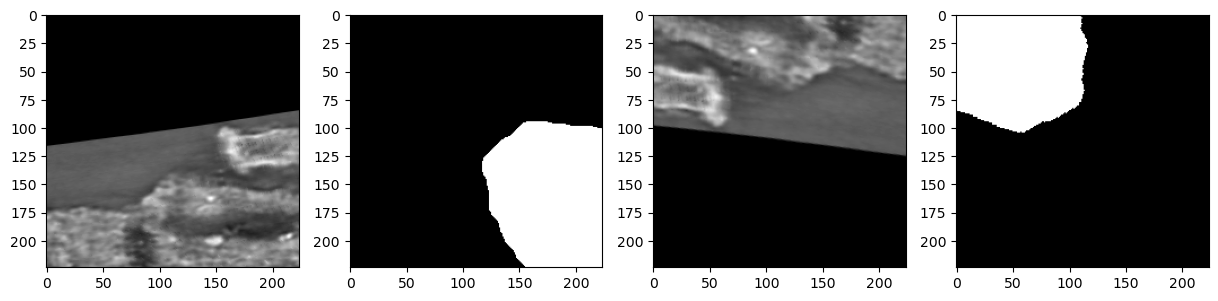

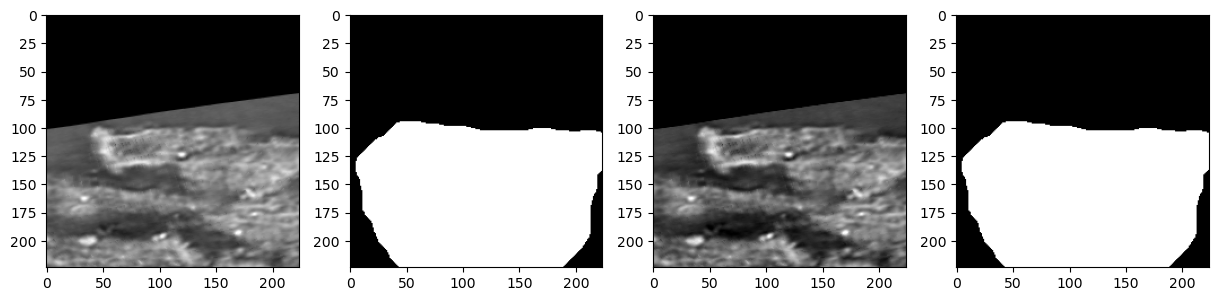

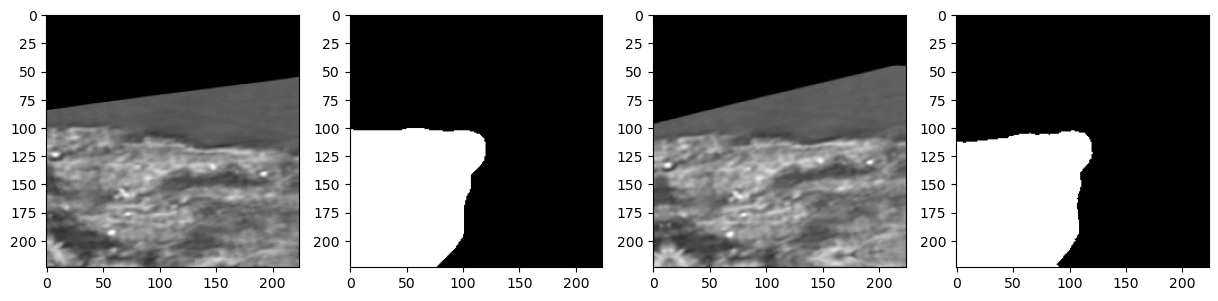

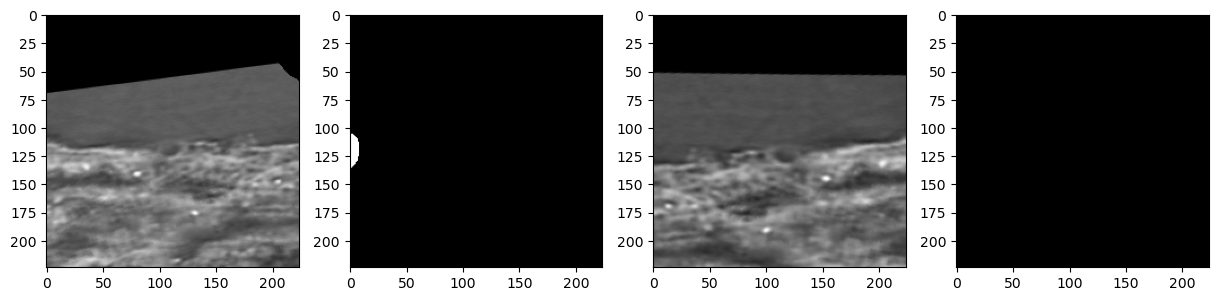

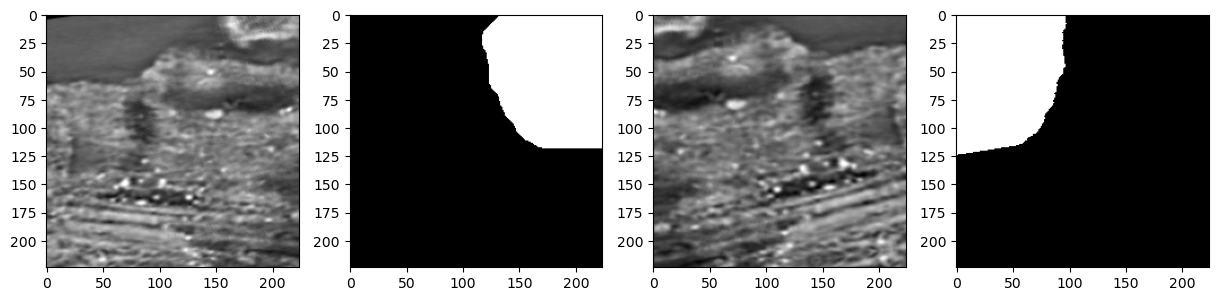

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48145

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone timm-resnest50d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14204024342900187
th: 0.15, fbeta: 0.14188477053043516
th: 0.2, fbeta: 0.14150883171527545
th: 0.25, fbeta: 0.18316553481522707
th: 0.3, fbeta: 0.20610171995040594
th: 0.35, fbeta: 0.21019732211609204
th: 0.4, fbeta: 0.2141813759539767
th: 0.45, fbeta: 0.21550191740586105


best_th: 0.45, fbeta: 0.21550191740586105
Epoch 1 - avg_train_loss: 0.6566  avg_val_loss: 0.5586  time: 129s
Epoch 1 - avgScore: 0.2155
Epoch 1 - Save Best Score: 0.2155 Model
Epoch 1 - Save Best Loss: 0.5586 Model


th: 0.5, fbeta: 0.21412803470568922


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14231485166887176
th: 0.15, fbeta: 0.14237427743323616
th: 0.2, fbeta: 0.20397008889278406
th: 0.25, fbeta: 0.21777348813256198
th: 0.3, fbeta: 0.2327867421034718
th: 0.35, fbeta: 0.25039379094462116
th: 0.4, fbeta: 0.26540251184499475
th: 0.45, fbeta: 0.2619261380774522


best_th: 0.4, fbeta: 0.26540251184499475
Epoch 2 - avg_train_loss: 0.4803  avg_val_loss: 0.4182  time: 130s
Epoch 2 - avgScore: 0.2654
Epoch 2 - Save Best Score: 0.2654 Model
Epoch 2 - Save Best Loss: 0.4182 Model


th: 0.5, fbeta: 0.2242973649571661


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.2892653625552225
th: 0.15, fbeta: 0.3408944508052113
th: 0.2, fbeta: 0.3627918148853249
th: 0.25, fbeta: 0.36190691793778784
th: 0.3, fbeta: 0.34878911724254036
th: 0.35, fbeta: 0.32563627010173085
th: 0.4, fbeta: 0.29504028993101644
th: 0.45, fbeta: 0.25397817985999743


best_th: 0.2, fbeta: 0.3627918148853249
Epoch 3 - avg_train_loss: 0.2922  avg_val_loss: 0.3232  time: 129s
Epoch 3 - avgScore: 0.3628
Epoch 3 - Save Best Score: 0.3628 Model
Epoch 3 - Save Best Loss: 0.3232 Model


th: 0.5, fbeta: 0.19505701809982082


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3720841001692083
th: 0.15, fbeta: 0.3717947164671358
th: 0.2, fbeta: 0.31052442760611887
th: 0.25, fbeta: 0.2507284488375881
th: 0.3, fbeta: 0.19896834434367672
th: 0.35, fbeta: 0.15177920129391476
th: 0.4, fbeta: 0.11148713374793877
th: 0.45, fbeta: 0.07929721190454912


best_th: 0.1, fbeta: 0.3720841001692083
Epoch 4 - avg_train_loss: 0.2198  avg_val_loss: 0.3475  time: 130s
Epoch 4 - avgScore: 0.3721
Epoch 4 - Save Best Score: 0.3721 Model
Epoch 4 - Save Best Loss: 0.3475 Model


th: 0.5, fbeta: 0.054227427249706424


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3825018454268434
th: 0.15, fbeta: 0.35555139103075023
th: 0.2, fbeta: 0.29323504184211757
th: 0.25, fbeta: 0.24264222546440567
th: 0.3, fbeta: 0.1998780696846434
th: 0.35, fbeta: 0.16423995270008027
th: 0.4, fbeta: 0.13236818467724737
th: 0.45, fbeta: 0.10339811206578013


best_th: 0.1, fbeta: 0.3825018454268434
Epoch 5 - avg_train_loss: 0.2042  avg_val_loss: 0.3508  time: 131s
Epoch 5 - avgScore: 0.3825
Epoch 5 - Save Best Score: 0.3825 Model
Epoch 5 - Save Best Loss: 0.3508 Model


th: 0.5, fbeta: 0.07889785756888462


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3597595760971109
th: 0.15, fbeta: 0.3726657609212401
th: 0.2, fbeta: 0.3633997874124491
th: 0.25, fbeta: 0.3375725779684373
th: 0.3, fbeta: 0.2977572313061322
th: 0.35, fbeta: 0.25261371481845274
th: 0.4, fbeta: 0.2072649943286121
th: 0.45, fbeta: 0.1655191920611011


best_th: 0.15, fbeta: 0.3726657609212401
Epoch 6 - avg_train_loss: 0.1910  avg_val_loss: 0.3768  time: 131s
Epoch 6 - avgScore: 0.3727


th: 0.5, fbeta: 0.12716402404365512


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39080238035409226
th: 0.15, fbeta: 0.39603603142920196
th: 0.2, fbeta: 0.38017424001527295
th: 0.25, fbeta: 0.3514224040140895
th: 0.3, fbeta: 0.31868452915042694
th: 0.35, fbeta: 0.2808938976779992
th: 0.4, fbeta: 0.24125443373559158
th: 0.45, fbeta: 0.20138239946861153


best_th: 0.15, fbeta: 0.39603603142920196
Epoch 7 - avg_train_loss: 0.1828  avg_val_loss: 0.3880  time: 130s
Epoch 7 - avgScore: 0.3960
Epoch 7 - Save Best Score: 0.3960 Model
Epoch 7 - Save Best Loss: 0.3880 Model


th: 0.5, fbeta: 0.16162285380517485


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4039842199219948
th: 0.15, fbeta: 0.37009078181625227
th: 0.2, fbeta: 0.316052208945937
th: 0.25, fbeta: 0.2600823388853584
th: 0.3, fbeta: 0.2057737492123419
th: 0.35, fbeta: 0.15775285247325344
th: 0.4, fbeta: 0.12163645963359274
th: 0.45, fbeta: 0.09331937263073


best_th: 0.1, fbeta: 0.4039842199219948
Epoch 8 - avg_train_loss: 0.1731  avg_val_loss: 0.4202  time: 131s
Epoch 8 - avgScore: 0.4040
Epoch 8 - Save Best Score: 0.4040 Model
Epoch 8 - Save Best Loss: 0.4202 Model


th: 0.5, fbeta: 0.07226050867986056


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3613902683185404
th: 0.15, fbeta: 0.3693138848015523
th: 0.2, fbeta: 0.35962082746907625
th: 0.25, fbeta: 0.3371317790641584
th: 0.3, fbeta: 0.30237855673601
th: 0.35, fbeta: 0.26065864832246155
th: 0.4, fbeta: 0.22117290554805583
th: 0.45, fbeta: 0.1839006305994132


best_th: 0.15, fbeta: 0.3693138848015523
Epoch 9 - avg_train_loss: 0.1641  avg_val_loss: 0.4014  time: 130s
Epoch 9 - avgScore: 0.3693


th: 0.5, fbeta: 0.14954925704137995


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34274831664457117
th: 0.15, fbeta: 0.2498025653006422
th: 0.2, fbeta: 0.17399348401769843
th: 0.25, fbeta: 0.11658778671407849
th: 0.3, fbeta: 0.0809936917420728
th: 0.35, fbeta: 0.057410910051053476
th: 0.4, fbeta: 0.04077924231533443
th: 0.45, fbeta: 0.029394871430339232


best_th: 0.1, fbeta: 0.34274831664457117
Epoch 10 - avg_train_loss: 0.1584  avg_val_loss: 0.4308  time: 128s
Epoch 10 - avgScore: 0.3427


th: 0.5, fbeta: 0.021253543171528576


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37694024292272416
th: 0.15, fbeta: 0.36367882944221425
th: 0.2, fbeta: 0.3412351184393597
th: 0.25, fbeta: 0.31567461152797305
th: 0.3, fbeta: 0.2867781925299024
th: 0.35, fbeta: 0.2566338963972501
th: 0.4, fbeta: 0.22612540586819038
th: 0.45, fbeta: 0.19633614451289888


best_th: 0.1, fbeta: 0.37694024292272416
Epoch 11 - avg_train_loss: 0.1468  avg_val_loss: 0.4811  time: 128s
Epoch 11 - avgScore: 0.3769


th: 0.5, fbeta: 0.16776912895203913


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3644431579663153
th: 0.15, fbeta: 0.34465805388526954
th: 0.2, fbeta: 0.3186999098655987
th: 0.25, fbeta: 0.2884425222409055
th: 0.3, fbeta: 0.25713051276051324
th: 0.35, fbeta: 0.2290935305331341
th: 0.4, fbeta: 0.20330331301019083
th: 0.45, fbeta: 0.17681078123914717


best_th: 0.1, fbeta: 0.3644431579663153
Epoch 12 - avg_train_loss: 0.1374  avg_val_loss: 0.5158  time: 128s
Epoch 12 - avgScore: 0.3644


th: 0.5, fbeta: 0.1497620899996241


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3553149192770739
th: 0.15, fbeta: 0.3319473812265459
th: 0.2, fbeta: 0.3092089923840602
th: 0.25, fbeta: 0.28447630873640994
th: 0.3, fbeta: 0.2597114219223794
th: 0.35, fbeta: 0.23575353486711556
th: 0.4, fbeta: 0.21097864721703594
th: 0.45, fbeta: 0.1847050080089933


best_th: 0.1, fbeta: 0.3553149192770739
Epoch 13 - avg_train_loss: 0.1360  avg_val_loss: 0.5010  time: 129s
Epoch 13 - avgScore: 0.3553


th: 0.5, fbeta: 0.162303496864421


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33155567968542704
th: 0.15, fbeta: 0.303978973406293
th: 0.2, fbeta: 0.2761091169839917
th: 0.25, fbeta: 0.2499382748224123
th: 0.3, fbeta: 0.22472187350750417
th: 0.35, fbeta: 0.20045430110968285
th: 0.4, fbeta: 0.17812140548581865
th: 0.45, fbeta: 0.15660628594613277


best_th: 0.1, fbeta: 0.33155567968542704
Epoch 14 - avg_train_loss: 0.1249  avg_val_loss: 0.5294  time: 128s
Epoch 14 - avgScore: 0.3316


th: 0.5, fbeta: 0.13493251793254776


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36470364751528217
th: 0.15, fbeta: 0.3675061215711879
th: 0.2, fbeta: 0.3632700339081359
th: 0.25, fbeta: 0.35472610633052715
th: 0.3, fbeta: 0.34183519478903285
th: 0.35, fbeta: 0.325678770640176
th: 0.4, fbeta: 0.30680636127154803
th: 0.45, fbeta: 0.2870839895721007


best_th: 0.15, fbeta: 0.3675061215711879
Epoch 15 - avg_train_loss: 0.1173  avg_val_loss: 0.4909  time: 129s
Epoch 15 - avgScore: 0.3675


th: 0.5, fbeta: 0.2647354438086961


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3767280695742174
th: 0.15, fbeta: 0.38844475723144445
th: 0.2, fbeta: 0.39498988266356977
th: 0.25, fbeta: 0.3966299102941571
th: 0.3, fbeta: 0.39454504381924543
th: 0.35, fbeta: 0.3896248130300958
th: 0.4, fbeta: 0.37885224600209894
th: 0.45, fbeta: 0.3636352772445324


best_th: 0.25, fbeta: 0.3966299102941571
Epoch 16 - avg_train_loss: 0.1093  avg_val_loss: 0.4835  time: 128s
Epoch 16 - avgScore: 0.3966


th: 0.5, fbeta: 0.3455025563394266


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2429560387002777
th: 0.15, fbeta: 0.2029534564026038
th: 0.2, fbeta: 0.1699434971118652
th: 0.25, fbeta: 0.1425087295421185
th: 0.3, fbeta: 0.11866999955105702
th: 0.35, fbeta: 0.09809160344089862
th: 0.4, fbeta: 0.07826719393383878
th: 0.45, fbeta: 0.06321740251105809


best_th: 0.1, fbeta: 0.2429560387002777
Epoch 17 - avg_train_loss: 0.1017  avg_val_loss: 0.6767  time: 128s
Epoch 17 - avgScore: 0.2430


th: 0.5, fbeta: 0.0520463651282323


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37596078093468976
th: 0.15, fbeta: 0.3749358558698417
th: 0.2, fbeta: 0.36760343081619434
th: 0.25, fbeta: 0.3543775312897629
th: 0.3, fbeta: 0.3364916234701653
th: 0.35, fbeta: 0.315818554922942
th: 0.4, fbeta: 0.29235765366119065
th: 0.45, fbeta: 0.2636896708281152


best_th: 0.1, fbeta: 0.37596078093468976
Epoch 18 - avg_train_loss: 0.0983  avg_val_loss: 0.5410  time: 129s
Epoch 18 - avgScore: 0.3760


th: 0.5, fbeta: 0.235554411743449


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3624172536787006
th: 0.15, fbeta: 0.3418962780945523
th: 0.2, fbeta: 0.3196170043915444
th: 0.25, fbeta: 0.2961755265940981
th: 0.3, fbeta: 0.26948041007081225
th: 0.35, fbeta: 0.24208686175431338
th: 0.4, fbeta: 0.21615576269771458
th: 0.45, fbeta: 0.19161975030202846


best_th: 0.1, fbeta: 0.3624172536787006
Epoch 19 - avg_train_loss: 0.0900  avg_val_loss: 0.6116  time: 129s
Epoch 19 - avgScore: 0.3624


th: 0.5, fbeta: 0.16797958316908015


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38625811691237594
th: 0.15, fbeta: 0.38156000029842047
th: 0.2, fbeta: 0.3728787142476215
th: 0.25, fbeta: 0.36103605954264056
th: 0.3, fbeta: 0.34483841416011407
th: 0.35, fbeta: 0.32842968830910924
th: 0.4, fbeta: 0.3106523701965019
th: 0.45, fbeta: 0.2891136863005765


best_th: 0.1, fbeta: 0.38625811691237594
Epoch 20 - avg_train_loss: 0.0908  avg_val_loss: 0.5882  time: 129s
Epoch 20 - avgScore: 0.3863


th: 0.5, fbeta: 0.26371640996303014


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3502807979458763
th: 0.15, fbeta: 0.3417171168041925
th: 0.2, fbeta: 0.33037450447917494
th: 0.25, fbeta: 0.31544474019332014
th: 0.3, fbeta: 0.29845483344386387
th: 0.35, fbeta: 0.28099859773206354
th: 0.4, fbeta: 0.2632401111018285
th: 0.45, fbeta: 0.24436966094442578


best_th: 0.1, fbeta: 0.3502807979458763
Epoch 21 - avg_train_loss: 0.0814  avg_val_loss: 0.6704  time: 129s
Epoch 21 - avgScore: 0.3503


th: 0.5, fbeta: 0.2243884669653799


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3253900475871338
th: 0.15, fbeta: 0.308287476904232
th: 0.2, fbeta: 0.2874801852029684
th: 0.25, fbeta: 0.2632223799763314
th: 0.3, fbeta: 0.2409702828717581
th: 0.35, fbeta: 0.21769362449132643
th: 0.4, fbeta: 0.19522069145625945
th: 0.45, fbeta: 0.1734703447818409


best_th: 0.1, fbeta: 0.3253900475871338
Epoch 22 - avg_train_loss: 0.0747  avg_val_loss: 0.7050  time: 128s
Epoch 22 - avgScore: 0.3254


th: 0.5, fbeta: 0.15109308110882505


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33892264124377447
th: 0.15, fbeta: 0.32963030333553767
th: 0.2, fbeta: 0.3151960474666685
th: 0.25, fbeta: 0.29660625826395326
th: 0.3, fbeta: 0.2764567107269111
th: 0.35, fbeta: 0.25475416683060936
th: 0.4, fbeta: 0.23091508884734488
th: 0.45, fbeta: 0.20482422643001547


best_th: 0.1, fbeta: 0.33892264124377447
Epoch 23 - avg_train_loss: 0.0725  avg_val_loss: 0.6675  time: 128s
Epoch 23 - avgScore: 0.3389


th: 0.5, fbeta: 0.17914884900922085


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3479634823244623
th: 0.15, fbeta: 0.3416076500333948
th: 0.2, fbeta: 0.3331767521834544
th: 0.25, fbeta: 0.3236259792495597
th: 0.3, fbeta: 0.31078605790398817
th: 0.35, fbeta: 0.29587798451667674
th: 0.4, fbeta: 0.2796148069897698
th: 0.45, fbeta: 0.2615131437779801


best_th: 0.1, fbeta: 0.3479634823244623
Epoch 24 - avg_train_loss: 0.0690  avg_val_loss: 0.6804  time: 130s
Epoch 24 - avgScore: 0.3480


th: 0.5, fbeta: 0.24323598702351673


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3306214374105046
th: 0.15, fbeta: 0.31801342420007306
th: 0.2, fbeta: 0.30225436201049827
th: 0.25, fbeta: 0.28295449780668025
th: 0.3, fbeta: 0.2622968245443891
th: 0.35, fbeta: 0.2420512543509976
th: 0.4, fbeta: 0.22261628744388345
th: 0.45, fbeta: 0.20142429658767247


best_th: 0.1, fbeta: 0.3306214374105046
Epoch 25 - avg_train_loss: 0.0675  avg_val_loss: 0.7418  time: 129s
Epoch 25 - avgScore: 0.3306


th: 0.5, fbeta: 0.17938172835604616


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3459280641690721
th: 0.15, fbeta: 0.33606160046066313
th: 0.2, fbeta: 0.3253128046360773
th: 0.25, fbeta: 0.3097059573977769
th: 0.3, fbeta: 0.2907137356083165
th: 0.35, fbeta: 0.27125159847226676
th: 0.4, fbeta: 0.2524788484707815
th: 0.45, fbeta: 0.23128401547782215


best_th: 0.1, fbeta: 0.3459280641690721
Epoch 26 - avg_train_loss: 0.0641  avg_val_loss: 0.6924  time: 130s
Epoch 26 - avgScore: 0.3459


th: 0.5, fbeta: 0.20567608341677876


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3348991159942636
th: 0.15, fbeta: 0.32419261329849364
th: 0.2, fbeta: 0.3099669951841213
th: 0.25, fbeta: 0.2911028057216213
th: 0.3, fbeta: 0.26974902833396625
th: 0.35, fbeta: 0.24864229915453373
th: 0.4, fbeta: 0.22930834934347855
th: 0.45, fbeta: 0.2079355757561842


best_th: 0.1, fbeta: 0.3348991159942636
Epoch 27 - avg_train_loss: 0.0604  avg_val_loss: 0.7333  time: 129s
Epoch 27 - avgScore: 0.3349


th: 0.5, fbeta: 0.1850022699692608


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3261531547530089
th: 0.15, fbeta: 0.3110540770314987
th: 0.2, fbeta: 0.2937601852357292
th: 0.25, fbeta: 0.272854812996709
th: 0.3, fbeta: 0.2515289026947681
th: 0.35, fbeta: 0.22917203101625117
th: 0.4, fbeta: 0.2052088753426923
th: 0.45, fbeta: 0.1799910556833525


best_th: 0.1, fbeta: 0.3261531547530089
Epoch 28 - avg_train_loss: 0.0614  avg_val_loss: 0.7730  time: 130s
Epoch 28 - avgScore: 0.3262


th: 0.5, fbeta: 0.15620244360388374


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3311243273160807
th: 0.15, fbeta: 0.31780068161512587
th: 0.2, fbeta: 0.3002131414673433
th: 0.25, fbeta: 0.2792054277215045
th: 0.3, fbeta: 0.2582977526879154
th: 0.35, fbeta: 0.23789082010086818
th: 0.4, fbeta: 0.21519074585449624
th: 0.45, fbeta: 0.19160827352494098


best_th: 0.1, fbeta: 0.3311243273160807
Epoch 29 - avg_train_loss: 0.0588  avg_val_loss: 0.7612  time: 130s
Epoch 29 - avgScore: 0.3311


th: 0.5, fbeta: 0.1677439777497771


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3269589869209271
th: 0.15, fbeta: 0.3117194732158963
th: 0.2, fbeta: 0.29340555526470263
th: 0.25, fbeta: 0.27144998961461125
th: 0.3, fbeta: 0.2494827674239904
th: 0.35, fbeta: 0.2288631791869916
th: 0.4, fbeta: 0.20841118023323568
th: 0.45, fbeta: 0.18607016552087843


best_th: 0.1, fbeta: 0.3269589869209271
Epoch 30 - avg_train_loss: 0.0572  avg_val_loss: 0.7821  time: 128s
Epoch 30 - avgScore: 0.3270


th: 0.5, fbeta: 0.16313754032997793


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4039842199219948
th: 0.15, fbeta: 0.37009078181625227
th: 0.2, fbeta: 0.316052208945937
th: 0.25, fbeta: 0.2600823388853584
th: 0.3, fbeta: 0.2057737492123419
th: 0.35, fbeta: 0.15775285247325344
th: 0.4, fbeta: 0.12163645963359274
th: 0.45, fbeta: 0.09331937263073


best_th: 0.1, fbeta: 0.4039842199219948


th: 0.5, fbeta: 0.07226050867986056


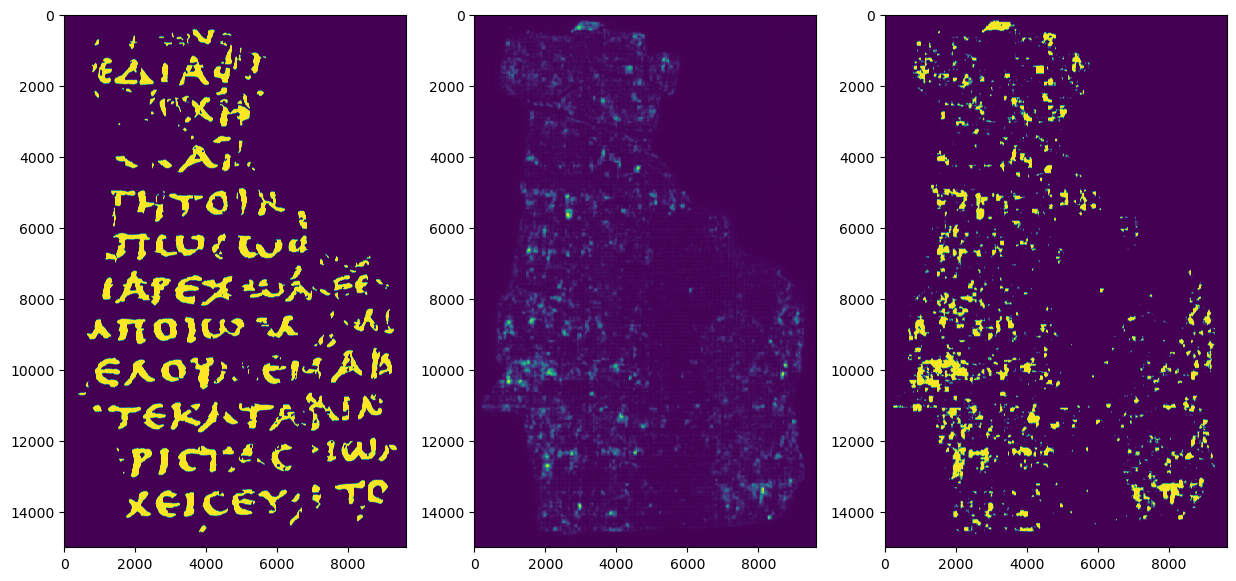

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.23594759e+08, 1.16804320e+07, 3.97258000e+06, 1.89643700e+06,
        1.10093800e+06, 7.28879000e+05, 4.79792000e+05, 3.10942000e+05,
        2.17273000e+05, 1.55391000e+05, 1.08842000e+05, 8.20090000e+04,
        6.29990000e+04, 4.66060000e+04, 3.83980000e+04, 3.03210000e+04,
        2.16950000e+04, 1.60000000e+04, 9.73800000e+03, 3.02500000e+03]),
 array([1.33099402e-04, 4.65392007e-02, 9.29453021e-02, 1.39351403e-01,
        1.85757505e-01, 2.32163606e-01, 2.78569707e-01, 3.24975809e-01,
        3.71381910e-01, 4.17788011e-01, 4.64194113e-01, 5.10600214e-01,
        5.57006315e-01, 6.03412417e-01, 6.49818518e-01, 6.96224619e-01,
        7.42630721e-01, 7.89036822e-01, 8.35442923e-01, 8.81849025e-01,
        9.28255126e-01]),
 <BarContainer object of 20 artists>)

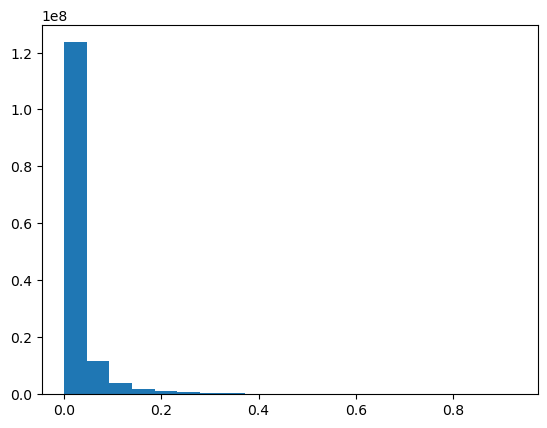

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000